### Lactic acid: ShapFS

In [53]:

import numpy as np
import shap
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression as PLSR
from traintest import *
from metrics import Metrics 
from visualization import *
import pickle
from dataloader import DataLoad
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
glucose = False
D = DataLoad(glucose=glucose)
D.load_data()
Xs, ys, Xt, yt, wl = D.X_source, D.y_source, D.X_target, D.y_target, D.wl

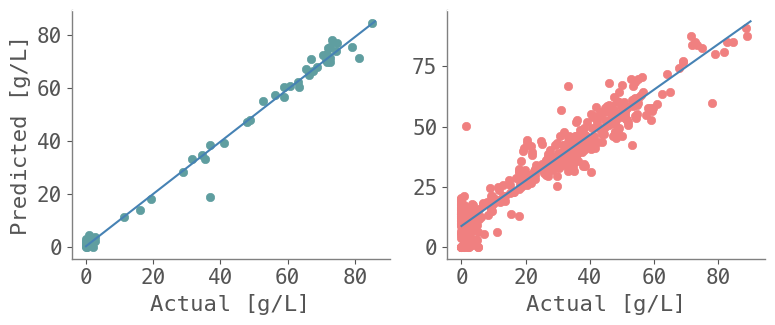

,Test on,Model,R-sq,RMSE,RMSEP [%],RPD
0,Source,PLSR,0.99,3.37079,3.9681,9.0
1,Target,PLSR,0.79,9.41562,10.59502,2.2


In [55]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
models = train(Xs_train, ys_train, plsr_comp=12)
test(models, Xs_test, ys_test, Xt, yt)

#### Calculate SHAP values: Model trained on source data, SHAP explains both source and target data

Root Mean Sq. Error % of Range for Source Test Set: 3.7


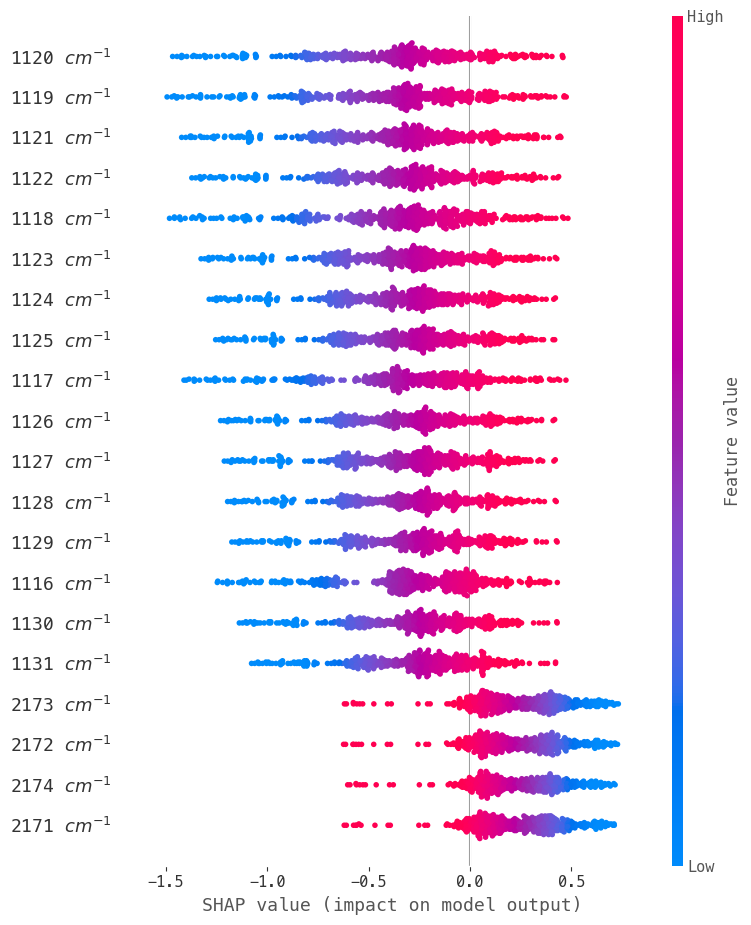

In [ ]:
N = 4 #number of source training data used for SHAP explainer
# SHAP values will be calcualted for the remaining source and all target data
X_mix =  np.vstack((Xs_test, Xs_train[N:,:], Xt[:len(Xs)-N,:])) #Xs_test.copy() #

# Train the regression model using source domain train set (ms)
ms = PLSR(n_components=12) 
ms.fit(Xs_train, ys_train)

# test on source test set
ys_pred = ms.predict(Xs_test)
rmsep_source = np.sqrt(MSE(ys_test, ys_pred)) * 100 / (max(ys) - min(ys))
print(f"Root Mean Sq. Error % of Range for Source Test Set: {rmsep_source:.1f}")

# Creating a SHAP explainer with regression model ms, giving only N (=4) datapoits from source train as reference
explainer_s = shap.PermutationExplainer(ms.predict, Xs_train[:N,:], feature_names=[f"{i}" " $cm^{-1}$" for i in wl])

# Taking rest of Source (train + test) and all of Target data to calculate joint SHAP values
shap_values = explainer_s(X_mix, max_evals=70000)

# with open('./results/shap_permutation_lacticacid.pkl', 'rb') as f:
#         shap_values = pickle.load(f)
        
# Visualize the SHAP values
shap.summary_plot(shap_values, X_mix,  feature_names=[f"{i}" " $cm^{-1}$" for i in wl])

# Calculate mean absolute SHAP values for each feature
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)

# Sort features based on mean SHAP values
sorted_indices_s = np.argsort(mean_abs_shap)[::-1]


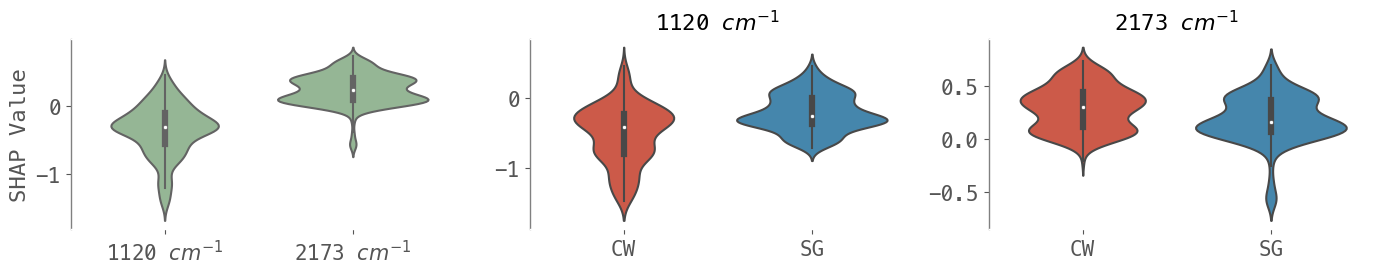

In [57]:
# saving the rank of features 
np.savetxt('./results/feature_index_ranked_lacticacid.txt', sorted_indices_s, fmt='%.2f', delimiter=',') 
# find the number of source samples used
n_source_data = len(Xs_test) + len(Xs_train[N:,:])
# select two features (from two regions) to compare their influence in decision making process across domains
r1_ind = 0 
r2_ind = 16 
r1 = sorted_indices_s[r1_ind]
r2 = sorted_indices_s[r2_ind]
shap_feature1 = shap_values.values[:,r1]
shap_feature2 = shap_values.values[:,r2]

# Violin plot comparison
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
sns.violinplot(data=[shap_feature1, shap_feature2], color='darkseagreen',alpha=0.7, ax=ax[0])
ax[0].set_xticks([0, 1], [f"{wl[r1]}" +  " $cm^{-1}$", f"{wl[r2]}" +  " $cm^{-1}$"])
ax[0].set_ylabel('SHAP Value')
ax[0].spines['left'].set_color('gray')

## taking region 1:
# seperate for source and target
shap_feature1_s = shap_feature1[:n_source_data]
shap_feature1_t = shap_feature1[n_source_data:]

# Violin plot comparison
sns.violinplot(data=[ shap_feature1_t, shap_feature1_s],  alpha= 0.7,ax=ax[1])
ax[1].set_xticks([0, 1], [ "CW", "SG",])
ax[1].spines['left'].set_color('gray')
ax[1].set_title(f"{wl[r1]}" + " $cm^{-1}$")
## taking region 2:
# seperate for source and target
shap_feature2_s = shap_feature2[:n_source_data]
shap_feature2_t = shap_feature2[n_source_data:]
# Violin plot comparison
sns.violinplot(data=[ shap_feature2_t, shap_feature2_s],  alpha= 0.7, ax=ax[2])
ax[2].set_xticks([0, 1], ["CW", "SG"])
ax[2].spines['left'].set_color('gray')
ax[2].set_title(f"{wl[r2]}" + " $cm^{-1}$")
plt.tight_layout()
# plt.savefig("./figures/shap_violine_lacticacid.jpeg", dpi=300)
plt.show()

### Rank features based on SHAP-values, find the optimum number of features, and retrain model using only these features


The 99.5 percentile SHAP value is 0.26537636632184214

Selected features index: [ 567  568  569  570  571  572  573  574  575  576  577  578  579  580
  581  582 1623 1624]

Their SHAP values: [0.31 0.36 0.39 0.41 0.41 0.4  0.39 0.38 0.37 0.36 0.36 0.35 0.34 0.33
 0.31 0.29 0.27 0.27]

Number of selected features: 18


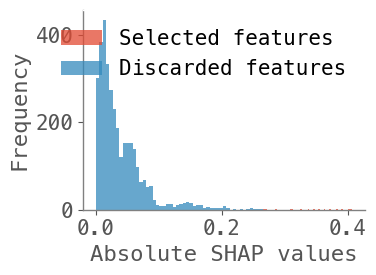

In [58]:
# Calculate the 99.5th percentile (top 0.5%)
perc = np.percentile(mean_abs_shap, 99.5)

# Create two sets of data: one below the percentile, one above
lower_data = mean_abs_shap[mean_abs_shap < perc]
upper_data = mean_abs_shap[mean_abs_shap >= perc]
selected_features = np.where(mean_abs_shap>= perc)[0]


print(f"\nThe 99.5 percentile SHAP value is {perc}")
print(f"\nSelected features index: {selected_features}")
print(f"\nTheir SHAP values: {mean_abs_shap[selected_features]}")
n_selected_features = len(selected_features)

print(f"\nNumber of selected features: {n_selected_features}")

fig, ax = plt.subplots(figsize=(4,3))
# Plot the histogram for upper_data (top 0.1% percentile)
n2, bins2, patches2 = ax.hist(upper_data, bins=50, alpha=0.75,  label='Selected features')
# Plot the histogram for lower_data (below 99.9th percentile)
n1, bins1, patches1 = ax.hist(lower_data, bins=50, alpha=0.75, label='Discarded features')

ax.set_xlabel('Absolute SHAP values')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
plt.tight_layout()
# plt.savefig("./figures/shap_value_frequency_distribution_lacticacid.jpeg", dpi=400)
plt.show()


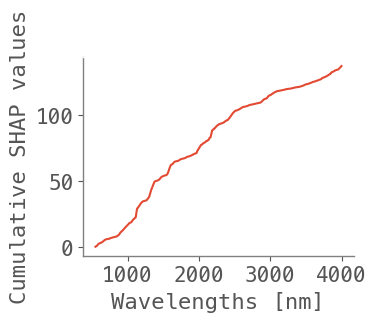

In [59]:

cumulative_importances = np.cumsum(mean_abs_shap)

# Plot cumulative importance
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(wl, cumulative_importances)

ax.set_xlabel('Wavelengths [nm]')
ax.set_ylabel('Cumulative SHAP values')

ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
plt.tight_layout()
# plt.savefig("./figures/shap_cumulative_lactic_acid.png", dpi=400)
plt.show()

Note: Not all selected features may be visible in the notebook. It is recommended to save the image for full visibility.

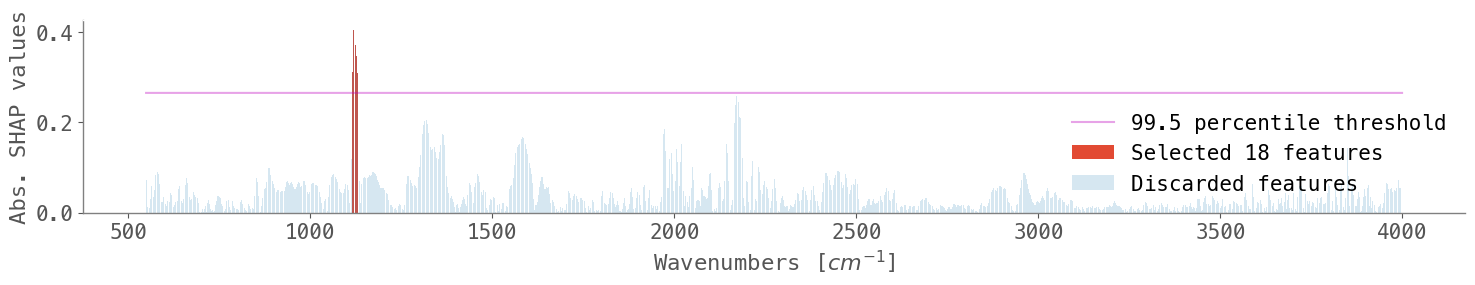

In [60]:

fig, ax = plt.subplots(figsize=(15, 3))
ax.bar(wl[selected_features], mean_abs_shap[selected_features], label=f'Selected {len(selected_features)} features')
ax.bar(wl, mean_abs_shap, alpha=0.2, label = 'Discarded features')
ax.plot(wl, [perc for i in range(len(wl))], c='m', alpha=0.36, label='99.5 percentile threshold')
ax.legend(frameon=False)
ax.set_xlabel("Wavenumbers [$cm^{-1}$]")
ax.set_ylabel("Abs. SHAP values")
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
plt.tight_layout()
plt.savefig("./figures/Top_feature_regions_lacticacid.jpeg", dpi=400)
plt.show()

Find best n_components for PLSR model

 Components 2 and validation error 7.8150
 Components 3 and validation error 3.8563
 Components 4 and validation error 3.1301
 Components 5 and validation error 3.1099
 Components 6 and validation error 3.0983
 Components 7 and validation error 3.0799
 Components 8 and validation error 3.0786
 Components 9 and validation error 3.0706
 Components 10 and validation error 3.0605
 Components 11 and validation error 3.0586


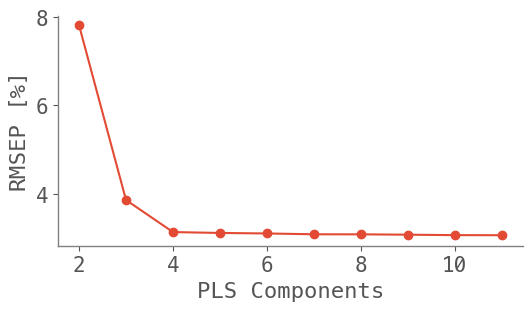

In [61]:

Xs_train_SF, Xs_test_SF, Xt_SF = Xs_train[:,selected_features], Xs_test[:,selected_features], Xt[:,selected_features]
## split of source trainset into validation and train to find the n_components (optional)
rmse_source_test = []
C = range(2, 12)
for k in C:
    ms = PLSR(n_components=k)
    ms.fit(Xs_train_SF, ys_train)
    rmse_source = np.sqrt(MSE(ys_train, ms.predict(Xs_train_SF)))
    print(f" Components {k} and validation error {rmse_source:.4f}")
    rmse_source_test.append(rmse_source)
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(C, rmse_source_test, '-o')
ax.set_xlabel("PLS Components")
ax.set_ylabel("RMSEP [%]")
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
plt.show()

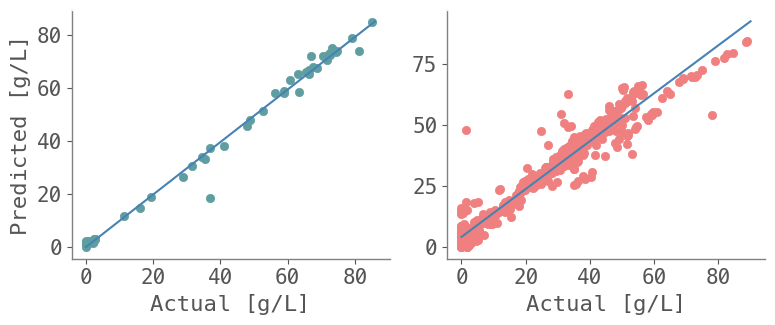

,Test on,Model,R-sq,RMSE,RMSEP [%],RPD
0,Source,PLSR,0.99,3.12218,3.67543,9.7
1,Target,PLSR,0.91,6.10012,6.86422,3.3


In [62]:
models =train(Xs_train_SF, ys_train, plsr_comp=4)
test( models, Xs_test_SF, ys_test, Xt_SF, yt)

#### Visualize the alignment between source and target with origianl features space and ShapFS domain invaraint features space

********** Before adaptation **********


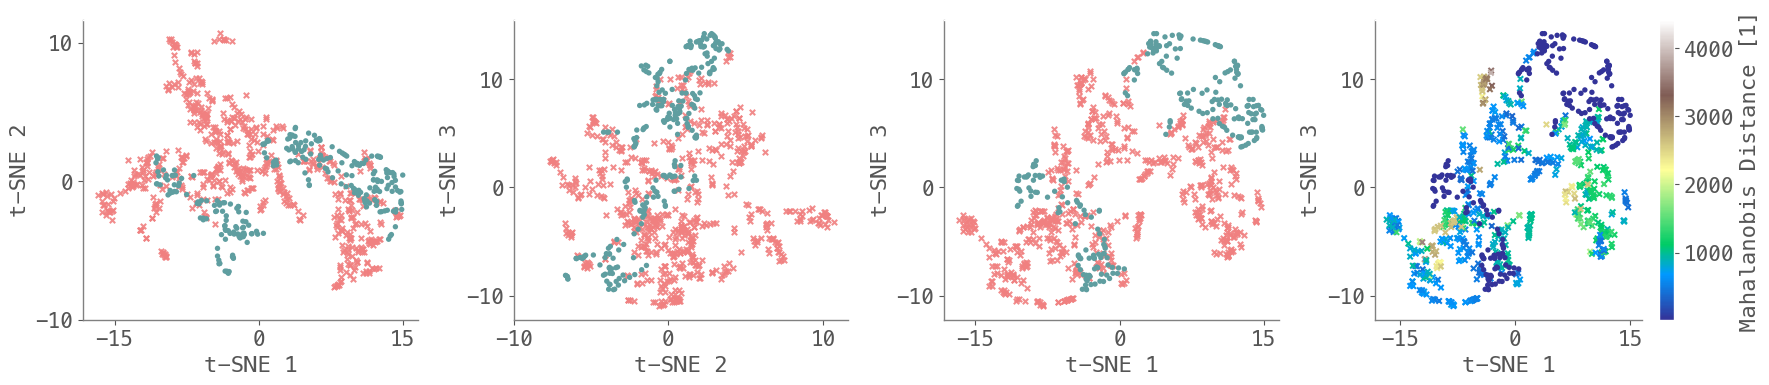

********** After adaptation **********


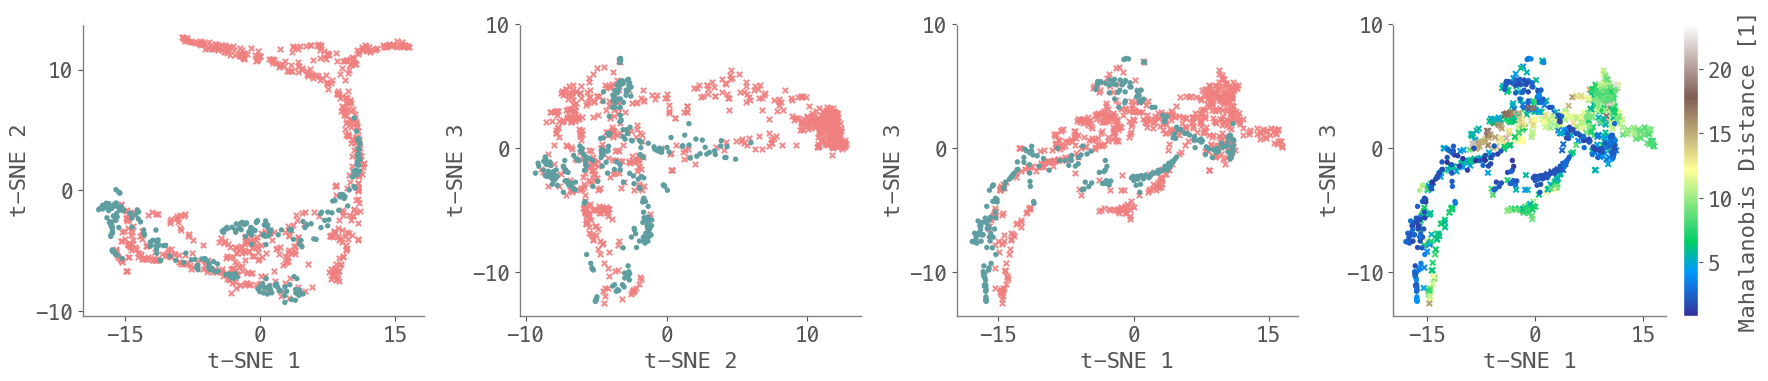

In [63]:

print(f"{'*' * 10} Before adaptation {'*' * 10}")
mds_before, mdt_before = calculate_mahalanobis_distance(Xs, Xt)
visualize_tsne_with_mahal_dist(Xs, Xt, mds_before, mdt_before, title='tSNE_before_da')

print(f"{'*' * 10} After adaptation {'*' * 10}")
Xs_SF = np.vstack(( Xs_train_SF, Xs_test_SF))
mds_after, mdt_after = calculate_mahalanobis_distance(Xs_SF, Xt_SF)
visualize_tsne_with_mahal_dist(Xs_SF, Xt_SF, mds_after, mdt_after, title='tSNE_after_XAI')

********** Before adaptation **********
Mahalanobis distances
Gaussian kernel density estimation


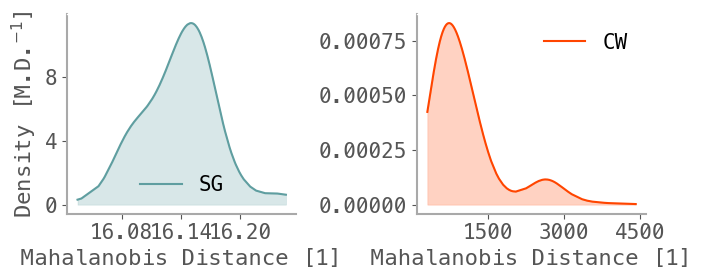

********** After adaptation **********
Mahalanobis distances
Gaussian kernel density estimation


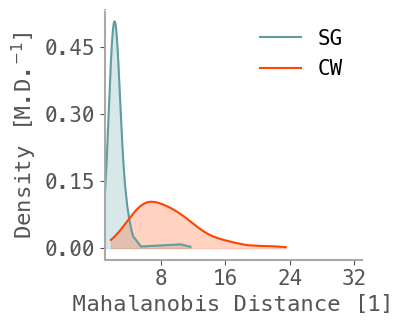

In [64]:
print(f"{'*' * 10} Before adaptation {'*' * 10}")
Gaussian_kernel_density_estimation(mds_before, mdt_before, label_s='SG', label_t='CW', single_figure=False)

print(f"{'*' * 10} After adaptation {'*' * 10}")
Gaussian_kernel_density_estimation(mds_after, mdt_after, label_s='SG', label_t='CW')


### Impact of increasing number of important features on prediction

In [65]:
results = []
for k in range(1, 101):
    features = sorted_indices_s[:k]
    if len(features)<20:
        plsr_comp = 5
    else:
        plsr_comp = 12
    models = train(Xs_train[:,features], ys_train, modelnames=['PLSR'], plsr_comp=plsr_comp)
    df = test(models, Xs_test[:,features], ys_test, Xt[:,features], yt, modelnames=['PLSR'], figure=False)
    df['n_features'] = [k for i in range(len(df))]
    results.append(df)
df = pd.concat(results)

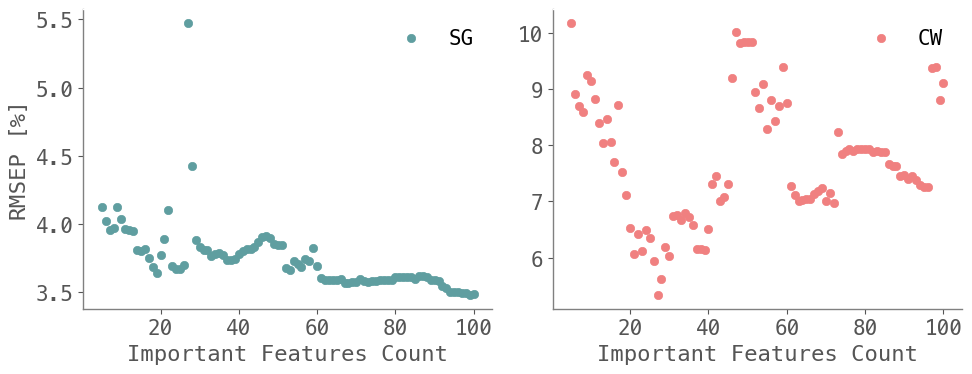

In [66]:
# visualize
S = df[df['Test on']=='Source'].iloc[4:,:]
S_plsr = S[S['Model']=='PLSR']
S_tf = S[S['Model']=='Transformer']
T = df[df['Test on']=='Target'].iloc[4:,:]
T_plsr = T[T['Model']=='PLSR']
T_tf = T[T['Model']=='Transformer']
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(S_plsr['n_features'], [float(i) for i in S_plsr['RMSEP [%]']], color='cadetblue', label='SG')
ax[1].scatter(T_plsr['n_features'], [float(i) for i in T_plsr['RMSEP [%]']], color='lightcoral', label='CW')

for k in range(2):
    ax[k].set_xlabel("Important Features Count")
    if k==0:
        ax[k].set_ylabel("RMSEP [%]")
    ax[k].spines['left'].set_color('gray')
    ax[k].spines['bottom'].set_color('gray')
    ax[k].legend(frameon=False)
fig.tight_layout()
plt.savefig("./Figures/ShapFS_imp_feat_vs_RMSEP_lacticacid.jpeg", dpi=300)

### Impact of increasing the number of features on identifying domain shift

In [67]:
# Load data
D.load_class_data()
x_train_c, y_train_c, x_test_c, y_test_c, wl_c = D.x_train_c, D.y_train_c, D.x_test_c, D.y_test_c, D.wl_c


In [68]:
# Test classification
results = []
for k in range(1, 101):
    features = sorted_indices_s[:k]
    acc = classification(x_train_c[:,features], x_test_c[:,features], y_train_c, y_test_c, wl_c[features])[1]
    results.append(acc * 100) # in percentage
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


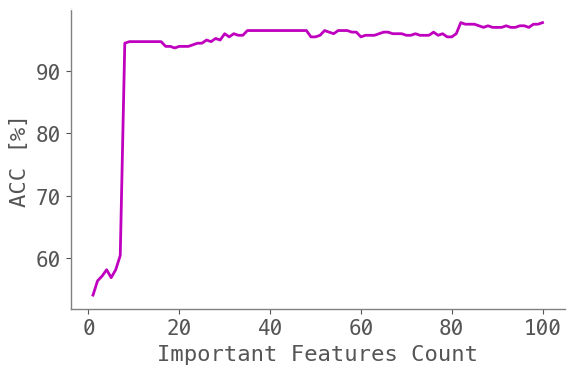

In [69]:
# visualize
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(1, 101), results, color='m', linewidth=2)
ax.set_xlabel("Important Features Count")
ax.set_ylabel("ACC [%]")
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.legend(frameon=False)
fig.tight_layout()